In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

from torchvision.transforms import v2

from dataset import FacialKeypointsDataset

In [11]:
transforms = v2.Compose([
    v2.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]),
    v2.ToImage(),
    v2.ToDtype(torch.float32),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=(-25, 25)),
    v2.RandomAffine(degrees=(-15, 15), translate=(0.2, 0.2), scale=(0.8, 1.2), shear=(-10, 10, -10, 10)),
    v2.RandomResizedCrop((224, 224), scale=(0.8, 1.0), antialias=True),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    v2.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    v2.RandomAutocontrast(p=0.2),
    v2.RandomEqualize(p=0.2),
])

In [12]:
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv', root_dir='data/test/', transform=transforms)
train_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv', root_dir='data/training/')

38.0
(224, 224, 3)
(68, 2)


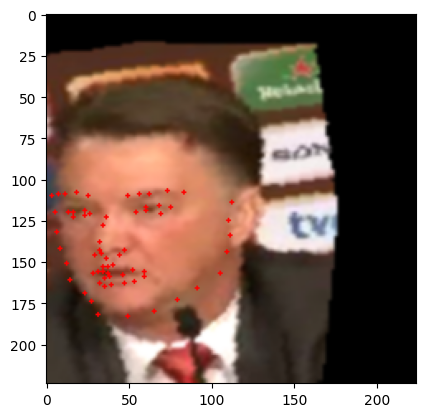

In [13]:
sample = test_dataset[12]


image = sample['image'].permute(1, 2, 0).numpy()
image = (image * 255).astype(np.uint8)
keypoints = sample['keypoints'].numpy()


print(image.shape)
print(keypoints.shape)

image = image.copy()


num_keypoints = keypoints.shape[0]

for i in range(num_keypoints):
    keypoints_y = int(keypoints[i, 1] * image.shape[1])
    keypoints_x = int(keypoints[i, 0] * image.shape[0])
    cv2.circle(image, (keypoints_x, keypoints_y), 1, (255, 0, 0), -1)

plt.imshow(image)


In [42]:
from torchvision.models import squeezenet1_1
import torch.nn as nn
import torch

model = squeezenet1_1()

# Freeze model weights
# for param in model.parameters():
#     param.requires_grad = False

# for param in model.layer4.parameters():
#     param.requires_grad = True

# Add on fully connected layers for the output of our model

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5),
    torch.nn.Conv2d(512, 68*2, kernel_size=(1, 1), stride=(1, 1)),
    torch.nn.ReLU(inplace=True),
    torch.nn.AdaptiveAvgPool2d(output_size=(1, 1)),
)

model.to('cuda:0')
model

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [43]:
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 111, 111]           1,792
              ReLU-2         [-1, 64, 111, 111]               0
         MaxPool2d-3           [-1, 64, 55, 55]               0
            Conv2d-4           [-1, 16, 55, 55]           1,040
              ReLU-5           [-1, 16, 55, 55]               0
            Conv2d-6           [-1, 64, 55, 55]           1,088
              ReLU-7           [-1, 64, 55, 55]               0
            Conv2d-8           [-1, 64, 55, 55]           9,280
              ReLU-9           [-1, 64, 55, 55]               0
             Fire-10          [-1, 128, 55, 55]               0
           Conv2d-11           [-1, 16, 55, 55]           2,064
             ReLU-12           [-1, 16, 55, 55]               0
           Conv2d-13           [-1, 64, 55, 55]           1,088
             ReLU-14           [-1, 64,